# Descrição do Trabalho (Introdução do Notebook)

Neste trabalho, o objetivo é aplicar técnicas de classificação para prever a ocorrência de falhas em dispositivos móveis, com base em dados históricos de uso, desempenho de bateria, conectividade e atividades do usuário.

Para isso, foi conduzida uma análise exploratória dos dados (EDA) a fim de:

- Compreender a distribuição das variáveis;

- Identificar valores faltantes, outliers e colinearidade;

- Criar novas features derivadas que possam melhorar o desempenho preditivo do modelo.

A variável-alvo (has_failure) foi construída a partir da ocorrência de desligamentos inesperados (shtdn_total > 0). Após criada, shtdn_total e variáveis derivadas foram removidas do conjunto de entrada para evitar vazamento de dados.

Durante a EDA:

- Foram analisadas variáveis originais e engenheiradas;

- Foi verificada sua relação com a variável-alvo por meio de correlação, visualização gráfica e diferença de médias por classe;

- Constatou-se que nenhuma feature isoladamente separa bem as classes, o que justifica a próxima etapa: seleção automática de variáveis e modelagem supervisionada com algoritmos de classificação.


Algoritmos que serão testados para a classificação:

1. Random Forest
- Por quê? Robusto a outliers, não exige normalização, lida bem com variáveis pouco informativas.

- Vantagem: Mostra a importância das features e evita overfitting com múltiplas árvores.

2. Gradient Boosting (ex: XGBoost ou LightGBM)
- Por quê? Excelente desempenho com dados tabulares e desbalanceados.

- Vantagem: Detecta interações entre variáveis e tende a superar outros métodos em acurácia.

3. Logistic Regression
- Por quê? Simples e interpretável.

- Vantagem: Boa como baseline. Útil para entender rapidamente quais variáveis têm impacto direto no target.

4. Support Vector Machine (SVM)
- Por quê? Útil se houver separação não linear.

- Vantagem: Funciona bem em espaços de alta dimensão, mesmo com poucas features relevantes.

# Importação das bibliotecas e leitura dos dados

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configurações de exibição
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Leitura dos dados
df = pd.read_csv("Moto_HW_DATA_hashed.csv")

# Visualização inicial
df.head()

,barcode_hashed,age_days,full_cap_min,pct_lvl_max,min_dchrg_fcc,dchrg_diff,EBL,total_chrg_cnt,cnt_USB_chrg,shtdn_total,btlow_total,call_drop_sum,call_tot_mins,calls_tot,msgs_tot,pics_tot,sst_poor_time_ratio,ratio_3G,ratio_4G,ratio_5G,wifi_hrs,wifi_connections,mobile_rx_MB,mobile_tx_MB,son_hrs,primary_mem_free_MB,bt_conns,CRASH_total,full_cap_min_ratio,pct_lvl_max_ratio,min_dchrg_fcc_ratio,dchrg_diff_ratio,EBL_ratio,total_chrg_cnt_ratio,cnt_USB_chrg_ratio,shtdn_total_ratio,btlow_total_ratio,call_drop_sum_ratio,call_tot_mins_ratio,calls_tot_ratio,msgs_tot_ratio,pics_tot_ratio,sst_poor_time_ratio_ratio,ratio_3G_ratio,ratio_4G_ratio,ratio_5G_ratio,wifi_hrs_ratio,wifi_connections_ratio,mobile_rx_MB_ratio,mobile_tx_MB_ratio,son_hrs_ratio,primary_mem_free_MB_ratio,bt_conns_ratio,CRASH_total_ratio
0,b926676dccc67406700c4c57cf055b3df237fc0ab286f6...,1516,3644678.5,94.75,0.0,125.25,14.5,3.0,0.00,0.75,1.25,0.25,3.75,34.25,211.25,60.50,6.1600,6.1800,93.81,0.0,16.25,7.00,171.25,11.25,4.25,4542.00,5.00,17.75,1.2203,1.0053,0.0,0.9881,1.0714,1.0000,0.0,2.0,1.50,0.0,0.6667,0.9855,0.8172,1.1607,1.2178,1.0447,0.9969,0.0,0.9118,1.000,1.9149,1.2500,0.8889,0.7617,0.1111,1.5357
1,7a2e95793e69ff2704030353bf27fc1ad13916d0370a25...,309,4744.0,96.75,5000.0,74.25,17.5,4.0,0.00,0.00,2.75,0.00,1.00,4.50,52.25,10.50,1.3150,5.8050,93.94,0.0,23.00,7.25,238.00,22.00,6.50,54590.75,4.50,1.50,1.0219,1.0052,1.0,1.0204,1.0000,1.2857,0.0,0.0,1.75,0.0,0.3333,2.6000,2.1667,2.2308,0.6386,0.8327,1.0135,0.0,0.9574,2.625,7.6545,13.6667,1.0000,1.2185,0.5000,1.0000
2,938897a9982050704df677787e41581a8cc9335d19b735...,1186,-1.0,60.00,5000.0,14.00,207.0,1.5,0.00,0.00,0.75,0.00,0.00,1.00,8.00,18.25,14.3175,0.0000,0.00,0.0,50.25,1.75,0.00,0.00,0.25,621.50,7.75,2.00,1.0000,0.9672,1.0,1.5455,1.1340,2.0000,0.0,0.0,0.50,0.0,0.0000,1.0000,1.0000,0.5208,0.2981,0.0000,0.0000,0.0,0.4357,0.750,0.0000,0.0000,0.0000,9.8087,0.0000,1.0000
3,6e878b24ff6ff1f6ffe4dc86f6095608800e1fce9a9c4b...,135,-1.0,90.75,-1.0,54.00,39.5,1.5,0.25,0.50,1.50,0.00,0.00,NaN,NaN,NaN,2.5400,3.0075,96.22,0.0,2.00,0.00,0.00,0.00,4.50,75106.75,0.00,1.75,1.0000,0.9622,1.0,1.0571,0.9750,1.0000,0.0,1.0,1.00,0.0,0.0000,0.0000,0.0000,0.0000,0.8306,0.2690,1.0509,0.0,1.0000,0.000,0.0000,0.0000,1.0000,1.0732,0.0000,1.3333
4,37219dd65adebf813d20af03c21bb6f1aa5b72815d964a...,640,-1.0,97.00,5000.0,32.00,62.0,2.0,0.00,1.00,0.00,0.00,0.00,NaN,NaN,NaN,3.9800,0.0000,0.00,0.0,2.00,0.00,0.00,0.00,2.00,3864.00,0.00,3.00,1.0000,1.0000,1.0,1.0000,1.0000,1.0000,0.0,1.0,0.00,0.0,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0,1.0000,0.000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000


# Exploração Básica dos Dados

#### 1. Verificação dos Tipos de Dados

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21063 entries, 0 to 21062
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   barcode_hashed             21063 non-null  object 
 1   age_days                   21063 non-null  int64  
 2   full_cap_min               21063 non-null  float64
 3   pct_lvl_max                21063 non-null  float64
 4   min_dchrg_fcc              21063 non-null  float64
 5   dchrg_diff                 21063 non-null  float64
 6   EBL                        21063 non-null  float64
 7   total_chrg_cnt             21063 non-null  float64
 8   cnt_USB_chrg               21063 non-null  float64
 9   shtdn_total                21063 non-null  float64
 10  btlow_total                21063 non-null  float64
 11  call_drop_sum              21063 non-null  float64
 12  call_tot_mins              21063 non-null  float64
 13  calls_tot                  11098 non-null  flo

 #### 2. Verificação de Valores Ausentes

In [113]:
missing_percent = df.isna().mean().sort_values(ascending=False)

print('---- Percentage of Missing Values (%) -----')
if missing_percent.sum():
    print((missing_percent[missing_percent > 0] * 100).round(2))
else:
    print('Nenhum valor ausente encontrado.')

---- Percentage of Missing Values (%) -----
calls_tot              47.31
msgs_tot               45.94
pics_tot               45.54
primary_mem_free_MB     0.04
dtype: float64


#### 3. Verificação de Linhas Duplicadas

In [114]:
print(f"No. of entirely duplicated rows: {df.duplicated().sum()}")

df[df.duplicated()]

No. of entirely duplicated rows: 0


,barcode_hashed,age_days,full_cap_min,pct_lvl_max,min_dchrg_fcc,dchrg_diff,EBL,total_chrg_cnt,cnt_USB_chrg,shtdn_total,btlow_total,call_drop_sum,call_tot_mins,calls_tot,msgs_tot,pics_tot,sst_poor_time_ratio,ratio_3G,ratio_4G,ratio_5G,wifi_hrs,wifi_connections,mobile_rx_MB,mobile_tx_MB,son_hrs,primary_mem_free_MB,bt_conns,CRASH_total,full_cap_min_ratio,pct_lvl_max_ratio,min_dchrg_fcc_ratio,dchrg_diff_ratio,EBL_ratio,total_chrg_cnt_ratio,cnt_USB_chrg_ratio,shtdn_total_ratio,btlow_total_ratio,call_drop_sum_ratio,call_tot_mins_ratio,calls_tot_ratio,msgs_tot_ratio,pics_tot_ratio,sst_poor_time_ratio_ratio,ratio_3G_ratio,ratio_4G_ratio,ratio_5G_ratio,wifi_hrs_ratio,wifi_connections_ratio,mobile_rx_MB_ratio,mobile_tx_MB_ratio,son_hrs_ratio,primary_mem_free_MB_ratio,bt_conns_ratio,CRASH_total_ratio


#### 4. Verificação dos Intervalos de Dados (Resumo Estatístico)

In [115]:
df.describe(include='all')

,barcode_hashed,age_days,full_cap_min,pct_lvl_max,min_dchrg_fcc,dchrg_diff,EBL,total_chrg_cnt,cnt_USB_chrg,shtdn_total,btlow_total,call_drop_sum,call_tot_mins,calls_tot,msgs_tot,pics_tot,sst_poor_time_ratio,ratio_3G,ratio_4G,ratio_5G,wifi_hrs,wifi_connections,mobile_rx_MB,mobile_tx_MB,son_hrs,primary_mem_free_MB,bt_conns,CRASH_total,full_cap_min_ratio,pct_lvl_max_ratio,min_dchrg_fcc_ratio,dchrg_diff_ratio,EBL_ratio,total_chrg_cnt_ratio,cnt_USB_chrg_ratio,shtdn_total_ratio,btlow_total_ratio,call_drop_sum_ratio,call_tot_mins_ratio,calls_tot_ratio,msgs_tot_ratio,pics_tot_ratio,sst_poor_time_ratio_ratio,ratio_3G_ratio,ratio_4G_ratio,ratio_5G_ratio,wifi_hrs_ratio,wifi_connections_ratio,mobile_rx_MB_ratio,mobile_tx_MB_ratio,son_hrs_ratio,primary_mem_free_MB_ratio,bt_conns_ratio,CRASH_total_ratio
count,21063,21063.000000,2.106300e+04,21063.000000,2.106300e+04,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,11098.000000,11386.000000,11471.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21054.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.00000,21063.000000,21063.000000,21063.000000
unique,21063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ba0cad5964caa693490e6dcb2c5aabc96934e5e2dd2259...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,891.115226,3.331318e+05,90.010242,1.097094e+05,71.769253,39.672414,7.128694,1.192710,0.558499,23.399789,0.049488,1.395645,16.885228,96.929668,36.056032,9.932066,12.073085,60.166595,0.340407,12.355275,4.801401,108.330611,10.966371,5.205605,39270.844393,1.837108,5.248321,0.539128,0.964664,0.942489,0.990888,1.006638,1.106897,0.332556,0.471836,1.222353,0.035504,0.484185,0.687668,0.710024,0.837850,3.888739,3.385923,1.511138,0.070326,1.037570,0.566358,1.122205,0.586365,0.98595,1.446740,0.337698,1.059382
std,NaN,521.096493,1.105046e+06,9.909344,7.113471e+05,37.993755,42.548399,13.017785,4.928158,0.679675,780.861824,0.191071,3.907488,29.215083,124.921060,77.705761,13.894284,22.842827,42.051627,4.562605,18.373397,8.957219,266.086707,45.194745,2.769159,44806.572790,10.234046,32.302843,32.574280,0.195770,0.233201,0.356736,0.545301,1.273419,1.364033,0.606222,19.479989,0.213145,2.440091,1.924068,3.111889,3.318831,87.569029,51.124072,69.890095,7.744133,4.483117,0.772146,13.194708,1.840541,0.49110,23.158995,1.390651,3.603018
min,NaN,45.000000,-1.000000e+00,0.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3454.000000,0.000000,-0.000500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,NaN,452.000000,-1.000000e+00,85.500000,-1.000000e+00,45.250000,18.500000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.250000,29.250000,5.000000,0.697500,0.015000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3.000000,5216.875000,0.

### Ajustes básicos

#### 1. Remover colunas com muitos nulos:


In [116]:
df = df.drop(columns=['calls_tot', 'msgs_tot', 'pics_tot'])

#### 2. Substituir valores inválidos (-1) por NaN:

In [117]:
df.replace(-1, np.nan, inplace=True)

#### 3. Remover identificador único (não ajuda na predição):

In [118]:
df.drop(columns=['barcode_hashed'], inplace=True)

In [119]:
df.describe(include='all')

,age_days,full_cap_min,pct_lvl_max,min_dchrg_fcc,dchrg_diff,EBL,total_chrg_cnt,cnt_USB_chrg,shtdn_total,btlow_total,call_drop_sum,call_tot_mins,sst_poor_time_ratio,ratio_3G,ratio_4G,ratio_5G,wifi_hrs,wifi_connections,mobile_rx_MB,mobile_tx_MB,son_hrs,primary_mem_free_MB,bt_conns,CRASH_total,full_cap_min_ratio,pct_lvl_max_ratio,min_dchrg_fcc_ratio,dchrg_diff_ratio,EBL_ratio,total_chrg_cnt_ratio,cnt_USB_chrg_ratio,shtdn_total_ratio,btlow_total_ratio,call_drop_sum_ratio,call_tot_mins_ratio,calls_tot_ratio,msgs_tot_ratio,pics_tot_ratio,sst_poor_time_ratio_ratio,ratio_3G_ratio,ratio_4G_ratio,ratio_5G_ratio,wifi_hrs_ratio,wifi_connections_ratio,mobile_rx_MB_ratio,mobile_tx_MB_ratio,son_hrs_ratio,primary_mem_free_MB_ratio,bt_conns_ratio,CRASH_total_ratio
count,21063.000000,1.003500e+04,21063.000000,1.368400e+04,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21054.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.000000,21063.00000,21063.000000,21063.000000,21063.000000
mean,891.115226,6.992294e+05,90.010242,1.688700e+05,71.769253,39.672414,7.128694,1.192710,0.558499,23.399789,0.049488,1.395645,9.932066,12.073085,60.166595,0.340407,12.355275,4.801401,108.330611,10.966371,5.205605,39270.844393,1.837108,5.248321,0.539128,0.964664,0.942489,0.990888,1.006638,1.106897,0.332556,0.471836,1.222353,0.035504,0.484185,0.687668,0.710024,0.837850,3.888739,3.385923,1.511138,0.070326,1.037570,0.566358,1.122205,0.586365,0.98595,1.446740,0.337698,1.059382
std,521.096493,1.518950e+06,9.909344,8.768741e+05,37.993755,42.548399,13.017785,4.928158,0.679675,780.861824,0.191071,3.907488,13.894284,22.842827,42.051627,4.562605,18.373397,8.957219,266.086707,45.194745,2.769159,44806.572790,10.234046,32.302843,32.574280,0.195770,0.233201,0.356736,0.545301,1.273419,1.364033,0.606222,19.479989,0.213145,2.440091,1.924068,3.111889,3.318831,87.569029,51.124072,69.890095,7.744133,4.483117,0.772146,13.194708,1.840541,0.49110,23.158995,1.390651,3.603018
min,45.000000,0.000000e+00,0.000000,-5.000000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3454.000000,0.000000,-0.000500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,452.000000,4.052875e+03,85.500000,4.000000e+03,45.250000,18.500000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.697500,0.015000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3.000000,5216.875000,0.000000,1.500000,1.000000,0.985000,1.000000,0.923700,0.919400,0.803600,0.000000,0.000000,0.666700,0.000000,0.000000,0.000000,0.000000,0.000000,0.643800,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.90910,1.000000,0.000000,0.666700
50%,859.000000,4.909750e+03,93.000000,4.936000e+03,67.000000,27.250000,3.500000,0.000000,0.500000,1.250000,0.000000,0.000000,3.510000,1.570000,83.485000,0.000000,7.000000,2.000000,0.000000,0.000000,5.000000,21952.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.200000,0.407400,0.113100,1.000000,0.874200,0.988300,0.000000,1.000000,0.400000,0.000000,0.000000,1.00000,1.002600,0.000000,1.000000
75%,1294.000000,5.069500e+03,97.500000,5.000000e+03,92.000000,43.000000,7.000000,0.750000,1.000000,2.250000,0.000000,1.250000,13.802500,10.690000,97.896250,0.000000,21.000000,7.000000,104.250000,11.000000,7.000000

# Processamento dos dados

#### 1. Colunas Redundantes

In [120]:
redundant_cols = [col for col in df.columns if df[col].nunique() <= 1]

print("Colunas com valor único")
print(redundant_cols)

Colunas com valor único
[]


#### 2. Colunas com tipo inadequado

In [121]:
float_cols = df.select_dtypes(include='float').columns
int_like_cols = [col for col in float_cols if df[col].dropna().apply(float.is_integer).all()]

print("Colunas float que contêm apenas inteiros (podem ser convertidas para int):")
print(int_like_cols)


Colunas float que contêm apenas inteiros (podem ser convertidas para int):
[]


#### 3. Criar a variável-alvo binária com base na shtdn_total


In [122]:
df['has_failure'] = (df['shtdn_total'] > 0).astype(int)
df.drop(columns=['shtdn_total', 'shtdn_total_ratio'], inplace=True)

#### 4. Correlação com a variável alvo (has_failure)

In [123]:
# 📈 Calcular correlação com a variável-alvo (has_failure)
correlation = df.corr(numeric_only=True)['has_failure'].drop('has_failure').sort_values(key=abs, ascending=False)

# Mostrar as 10 mais correlacionadas (positiva ou negativamente)
print("Top 10 variáveis mais correlacionadas com falha (has_failure):")
print(correlation.head(10))

Top 10 variáveis mais correlacionadas com falha (has_failure):
wifi_hrs               -0.099008
total_chrg_cnt          0.062565
EBL                    -0.059468
son_hrs_ratio           0.054534
pct_lvl_max_ratio       0.050821
min_dchrg_fcc_ratio     0.048318
total_chrg_cnt_ratio    0.043932
EBL_ratio               0.042556
dchrg_diff_ratio        0.042037
age_days                0.038781
Name: has_failure, dtype: float64


# Visualização de variáveis relevantes

#### 1. Visualização com Boxplots e KDEs para variáveis importantes

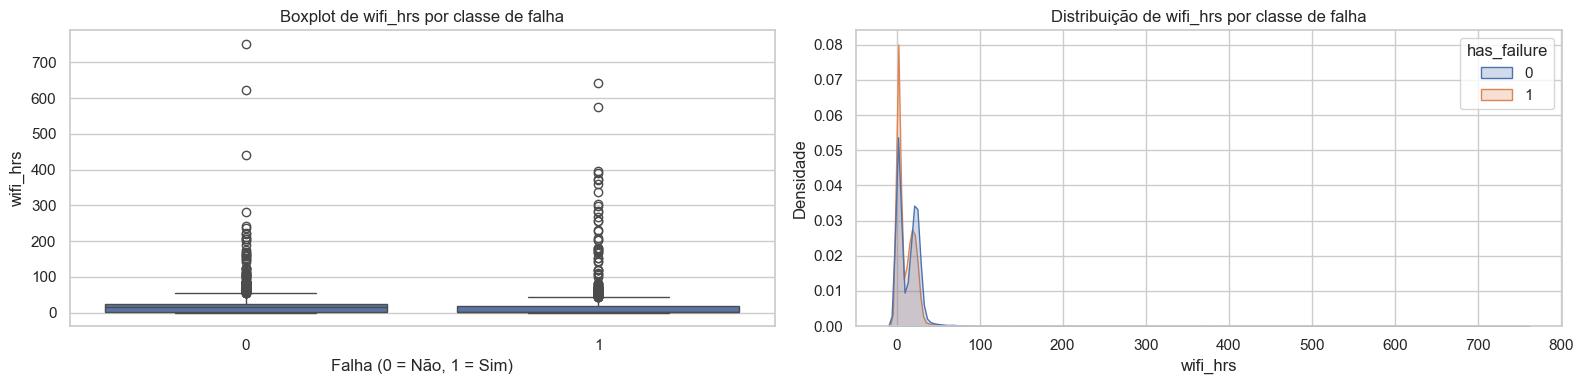

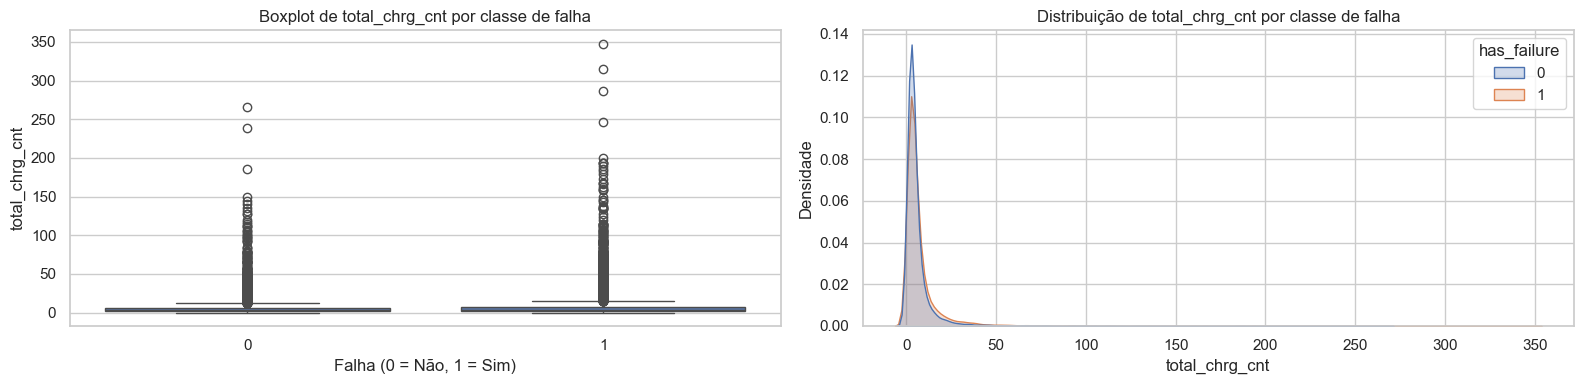

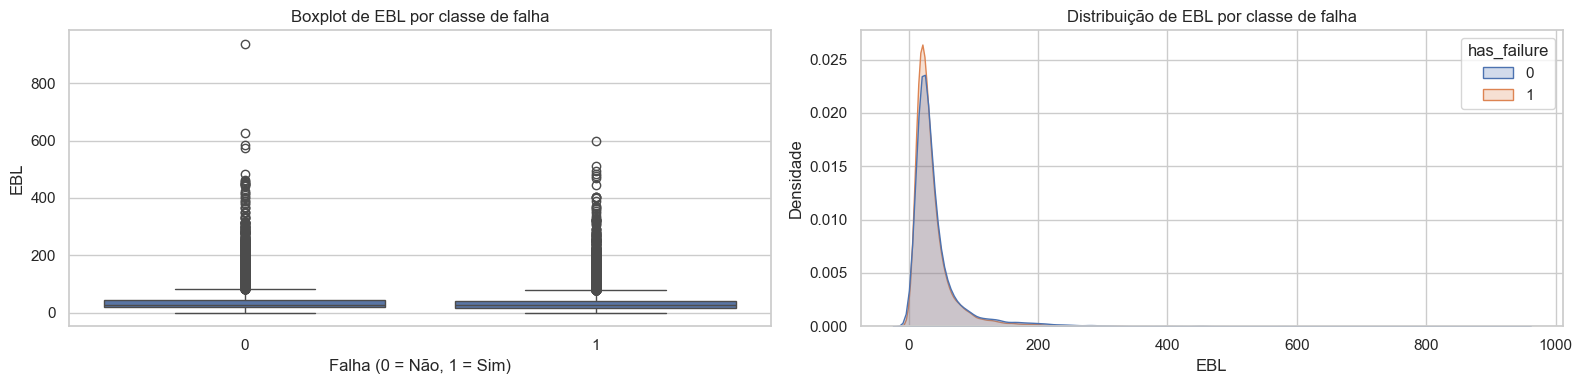

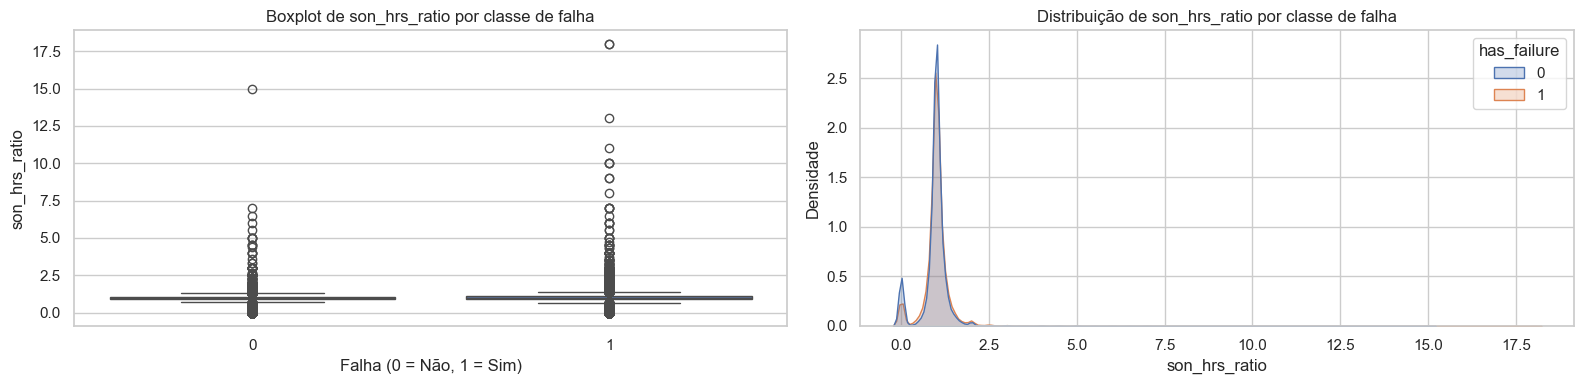

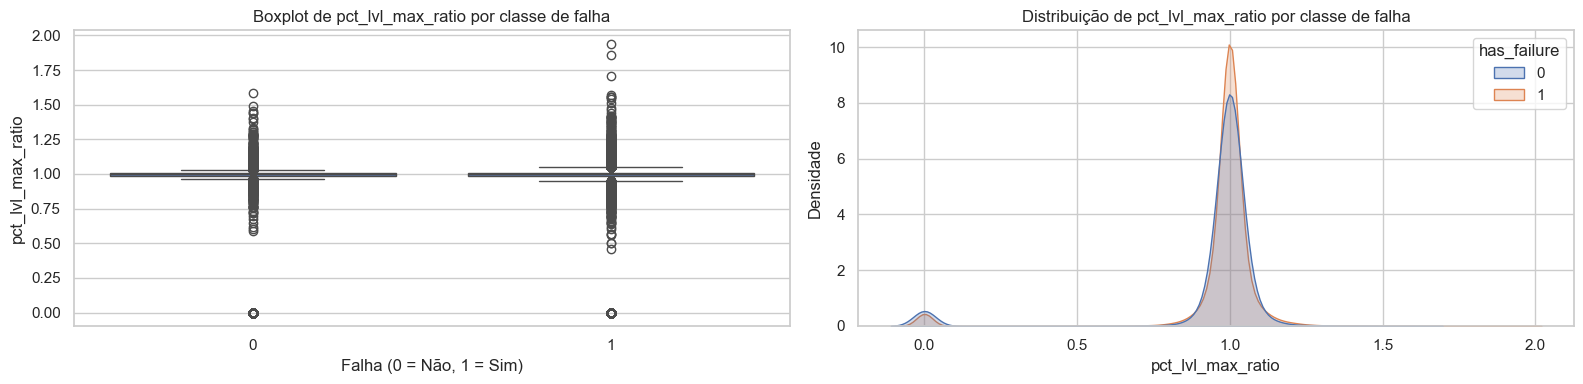

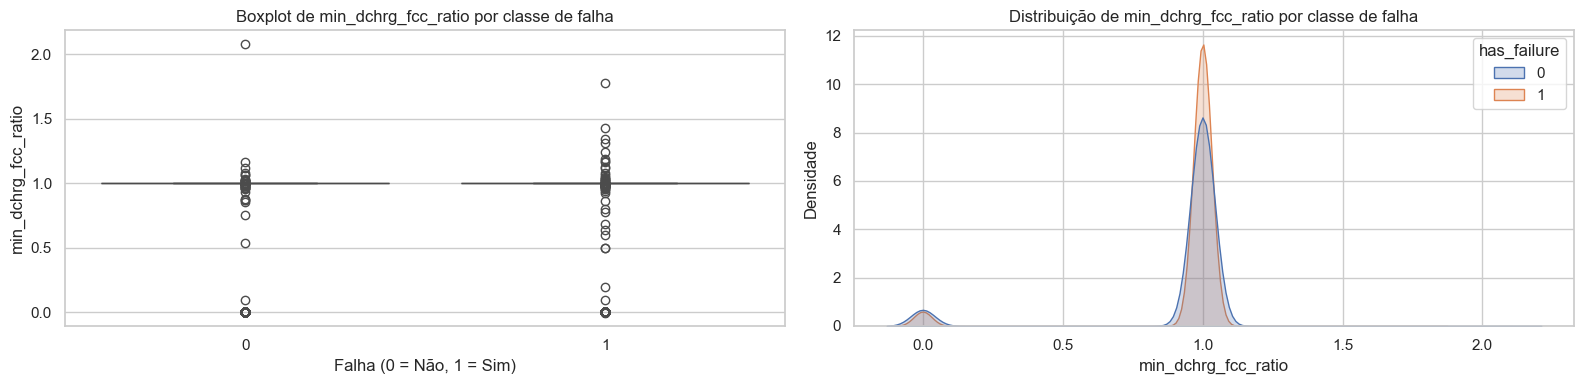

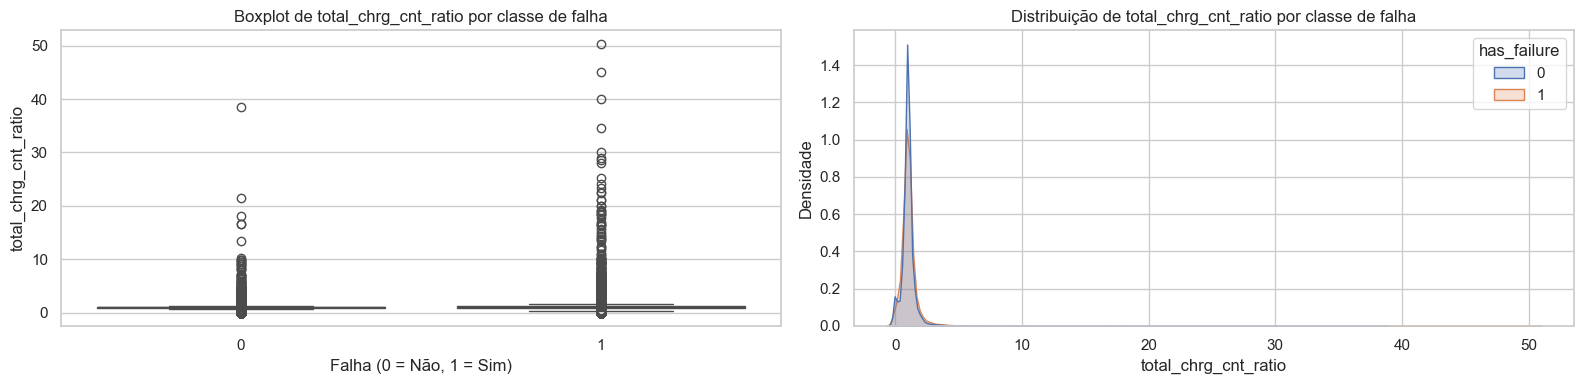

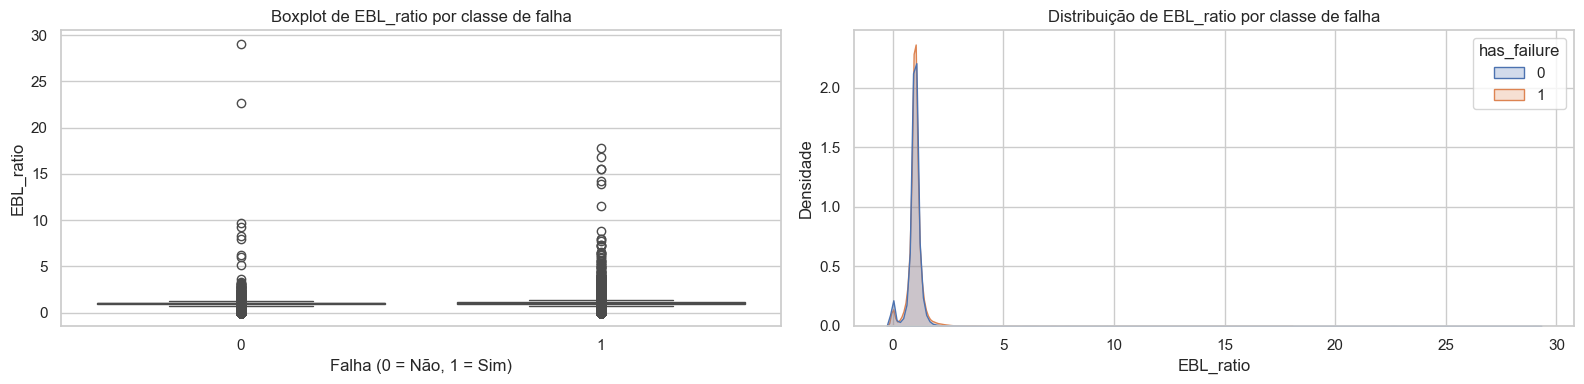

In [124]:
top_vars = [
    'wifi_hrs',
    'total_chrg_cnt', 'EBL', 'son_hrs_ratio',
    'pct_lvl_max_ratio', 'min_dchrg_fcc_ratio',
    'total_chrg_cnt_ratio', 'EBL_ratio'
]

import matplotlib.pyplot as plt
import seaborn as sns

for col in top_vars:
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    
    # Boxplot
    sns.boxplot(data=df, x='has_failure', y=col, ax=axes[0])
    axes[0].set_title(f'Boxplot de {col} por classe de falha')
    axes[0].set_xlabel('Falha (0 = Não, 1 = Sim)')
    axes[0].set_ylabel(col)

    # KDE (curva de densidade)
    sns.kdeplot(data=df, x=col, hue='has_failure', fill=True, common_norm=False, ax=axes[1])
    axes[1].set_title(f'Distribuição de {col} por classe de falha')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Densidade')

    plt.tight_layout()
    plt.show()


#### 2. Matriz de Correlação Completa com Heatmap

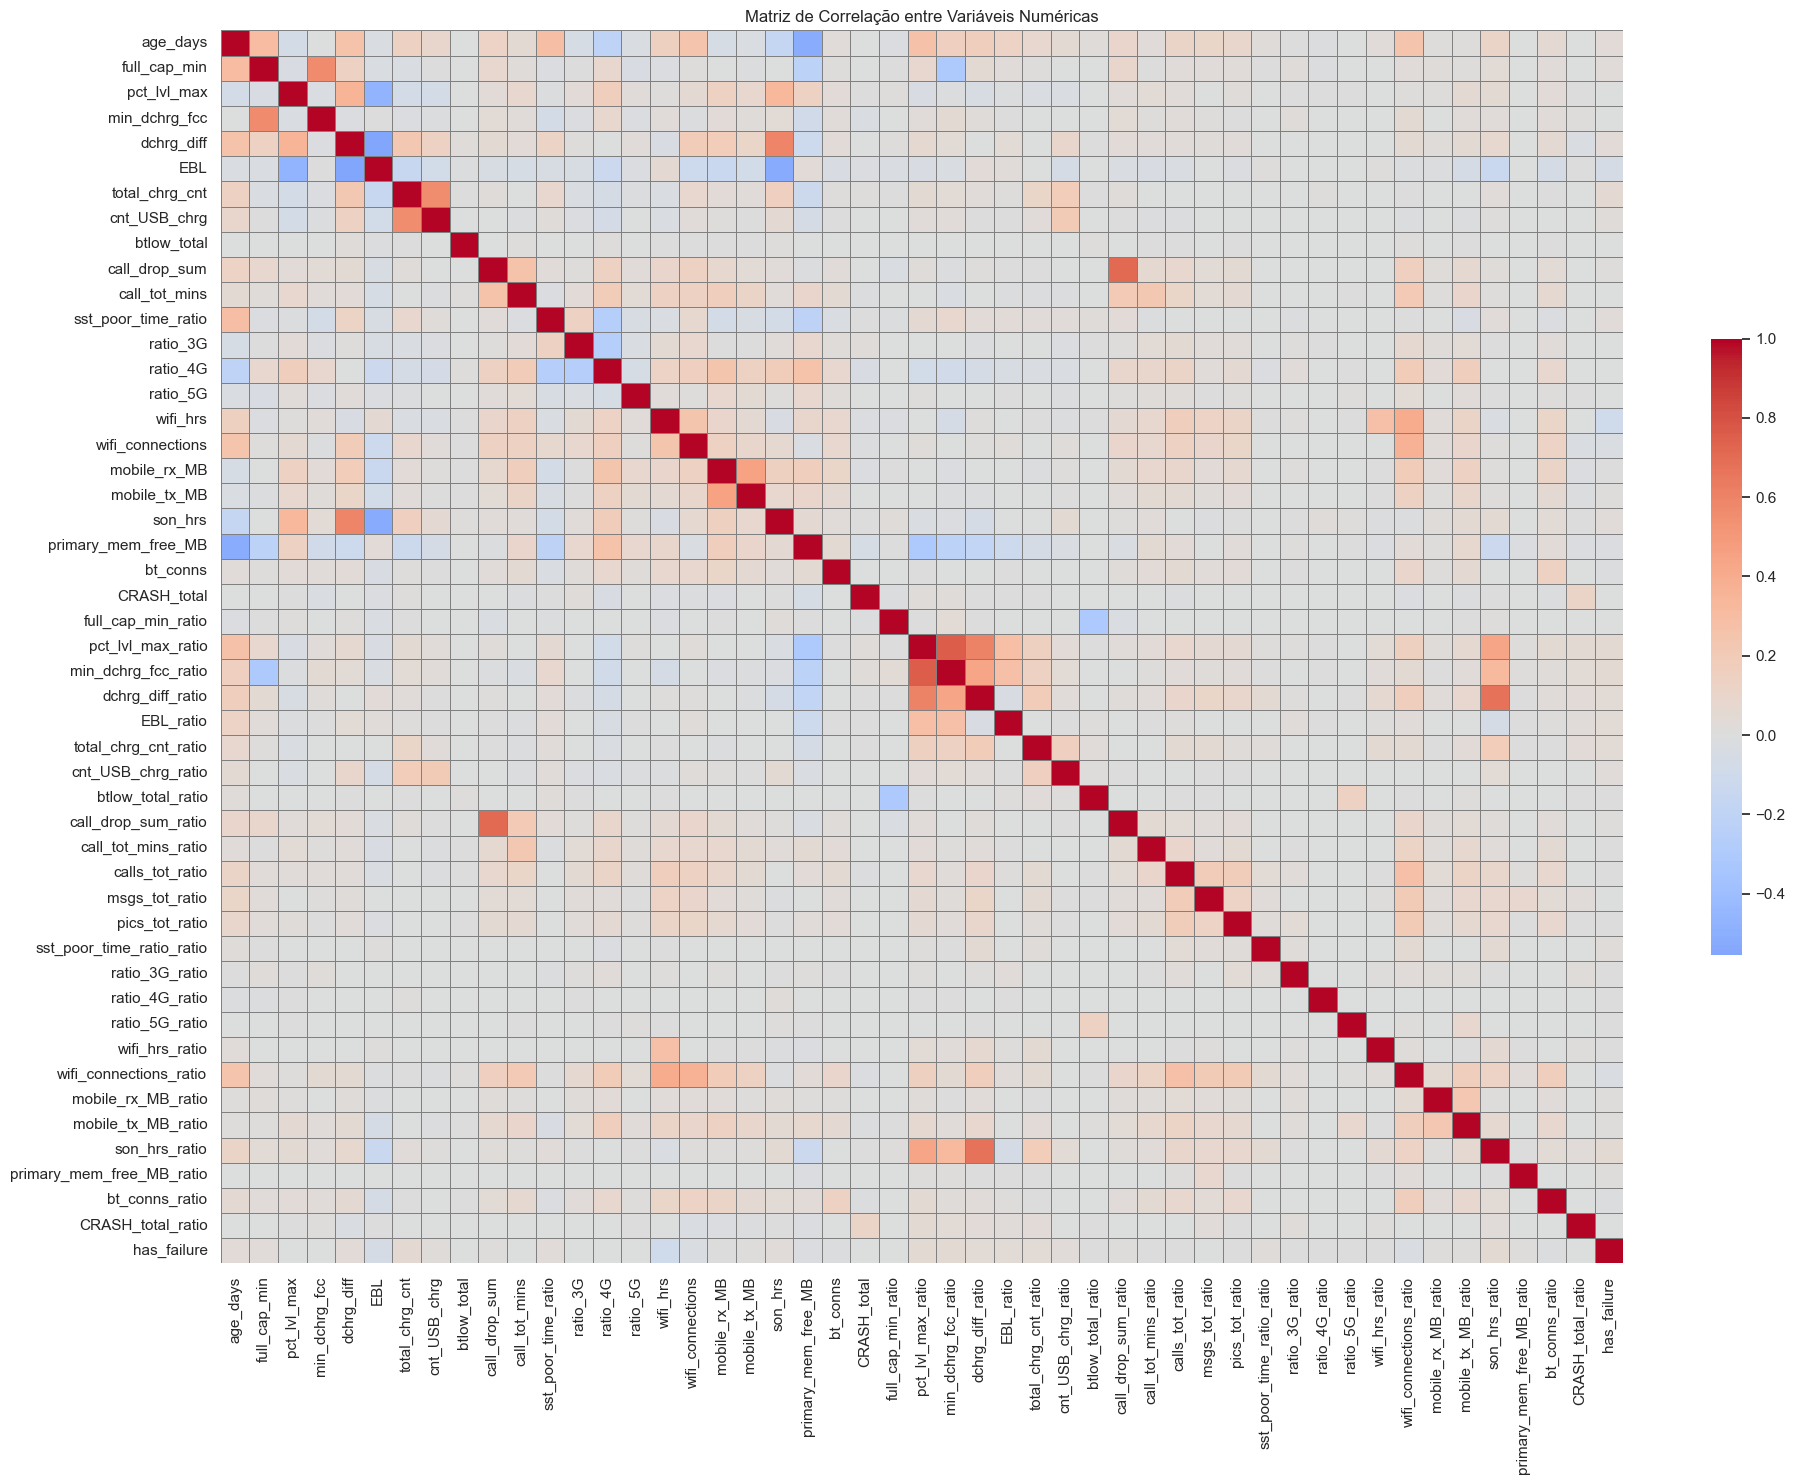

In [125]:
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", center=0,
            linewidths=0.5, linecolor='gray', cbar_kws={"shrink": 0.5})
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()


In [126]:
limite_correlacao = 0.5

corr_matrix = df.select_dtypes(include=[np.number]).corr()

corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

corr_pairs.columns = ['Variável_1', 'Variável_2', 'Correlação']
corr_pairs = corr_pairs.loc[abs(corr_pairs['Correlação']) >= limite_correlacao]
corr_pairs = corr_pairs.sort_values(by='Correlação', ascending=False)

print(f"Pares com correlação maior que {limite_correlacao}:")
corr_pairs


Pares com correlação maior que 0.5:


,Variável_1,Variável_2,Correlação
876,pct_lvl_max_ratio,min_dchrg_fcc_ratio,0.762636
417,call_drop_sum,call_drop_sum_ratio,0.711708
940,dchrg_diff_ratio,son_hrs_ratio,0.677803
877,pct_lvl_max_ratio,dchrg_diff_ratio,0.601083
200,dchrg_diff,son_hrs,0.598737
49,full_cap_min,min_dchrg_fcc,0.564268
273,total_chrg_cnt,cnt_USB_chrg,0.553265
19,age_days,primary_mem_free_MB,-0.515159
243,EBL,son_hrs,-0.523838
186,dchrg_diff,EBL,-0.555208


#### 3. Remover variáveis redundantes a partir da correlação

In [127]:
# Selecionar apenas variáveis numéricas (sem a target)
X = df.select_dtypes(include=[np.number]).drop(columns=['has_failure'], errors='ignore')

# 1. Pares altamente correlacionados
corr_matrix = X.corr().abs()
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Var1', 'Var2', 'Correlation']
high_corr_pairs = corr_pairs[corr_pairs['Correlation'] > 0.9]

print("\n Pares de variáveis com correlação > 0.9:")
print(high_corr_pairs.sort_values(by='Correlation', ascending=False))

suggest_remove_by_corr = high_corr_pairs['Var2'].unique().tolist()

# 2. VIF (Variance Inflation Factor)
print("\n Calculando VIF para todas as variáveis...")

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
X_filled = X.fillna(X.mean())
vif_data["VIF"] = [variance_inflation_factor(X_filled.values, i) for i in range(X_filled.shape[1])]


print("\n VIF das variáveis:")
print(vif_data.sort_values(by="VIF", ascending=False))

# Variáveis com VIF > 10
suggest_remove_by_vif = vif_data[vif_data["VIF"] > 10]["Variable"].tolist()

# Combinar sugestões, sem repetir
suggest_to_remove = sorted(set(suggest_remove_by_corr + suggest_remove_by_vif))

print("\n Variáveis sugeridas para remoção (com base em correlação e/ou VIF):")
print(suggest_to_remove)


 Pares de variáveis com correlação > 0.9:
Empty DataFrame
Columns: [Var1, Var2, Correlation]
Index: []

 Calculando VIF para todas as variáveis...

 VIF das variáveis:
                     Variable         VIF
24          pct_lvl_max_ratio  102.554634
25        min_dchrg_fcc_ratio   66.109031
2                 pct_lvl_max   38.430418
26           dchrg_diff_ratio   22.281074
4                  dchrg_diff   11.241697
44              son_hrs_ratio    9.976447
19                    son_hrs    9.398587
0                    age_days    8.665225
27                  EBL_ratio    5.322249
13                   ratio_4G    4.775827
1                full_cap_min    3.590079
20        primary_mem_free_MB    2.903098
5                         EBL    2.703901
41     wifi_connections_ratio    2.490664
9               call_drop_sum    2.280854
31        call_drop_sum_ratio    2.093195
15                   wifi_hrs    2.064587
6              total_chrg_cnt    2.026541
3               min_dchrg_fcc    

In [128]:
variaveis_para_remover = ['dchrg_diff_ratio', 'min_dchrg_fcc_ratio', 'pct_lvl_max_ratio']
df.drop(columns=variaveis_para_remover, inplace=True)

print("Colunas atuais:", df.columns.tolist())

Colunas atuais: ['age_days', 'full_cap_min', 'pct_lvl_max', 'min_dchrg_fcc', 'dchrg_diff', 'EBL', 'total_chrg_cnt', 'cnt_USB_chrg', 'btlow_total', 'call_drop_sum', 'call_tot_mins', 'sst_poor_time_ratio', 'ratio_3G', 'ratio_4G', 'ratio_5G', 'wifi_hrs', 'wifi_connections', 'mobile_rx_MB', 'mobile_tx_MB', 'son_hrs', 'primary_mem_free_MB', 'bt_conns', 'CRASH_total', 'full_cap_min_ratio', 'EBL_ratio', 'total_chrg_cnt_ratio', 'cnt_USB_chrg_ratio', 'btlow_total_ratio', 'call_drop_sum_ratio', 'call_tot_mins_ratio', 'calls_tot_ratio', 'msgs_tot_ratio', 'pics_tot_ratio', 'sst_poor_time_ratio_ratio', 'ratio_3G_ratio', 'ratio_4G_ratio', 'ratio_5G_ratio', 'wifi_hrs_ratio', 'wifi_connections_ratio', 'mobile_rx_MB_ratio', 'mobile_tx_MB_ratio', 'son_hrs_ratio', 'primary_mem_free_MB_ratio', 'bt_conns_ratio', 'CRASH_total_ratio', 'has_failure']


#### 4. Engenharia de atributos (Feature Engineering)

In [129]:
# 1. Ciclos de carga por dia de uso
df['battery_cycles_per_day'] = df['total_chrg_cnt'] / df['age_days']

# 2. Proporção de cargas via USB (evita divisão por zero com clip)
df['usb_charge_ratio'] = (df['cnt_USB_chrg'] / df['total_chrg_cnt'].clip(lower=1)).fillna(0)

# 3. Indicador de memória baixa (flag binário)
df['low_memory_flag'] = (df['primary_mem_free_MB'] < 500).astype(int)

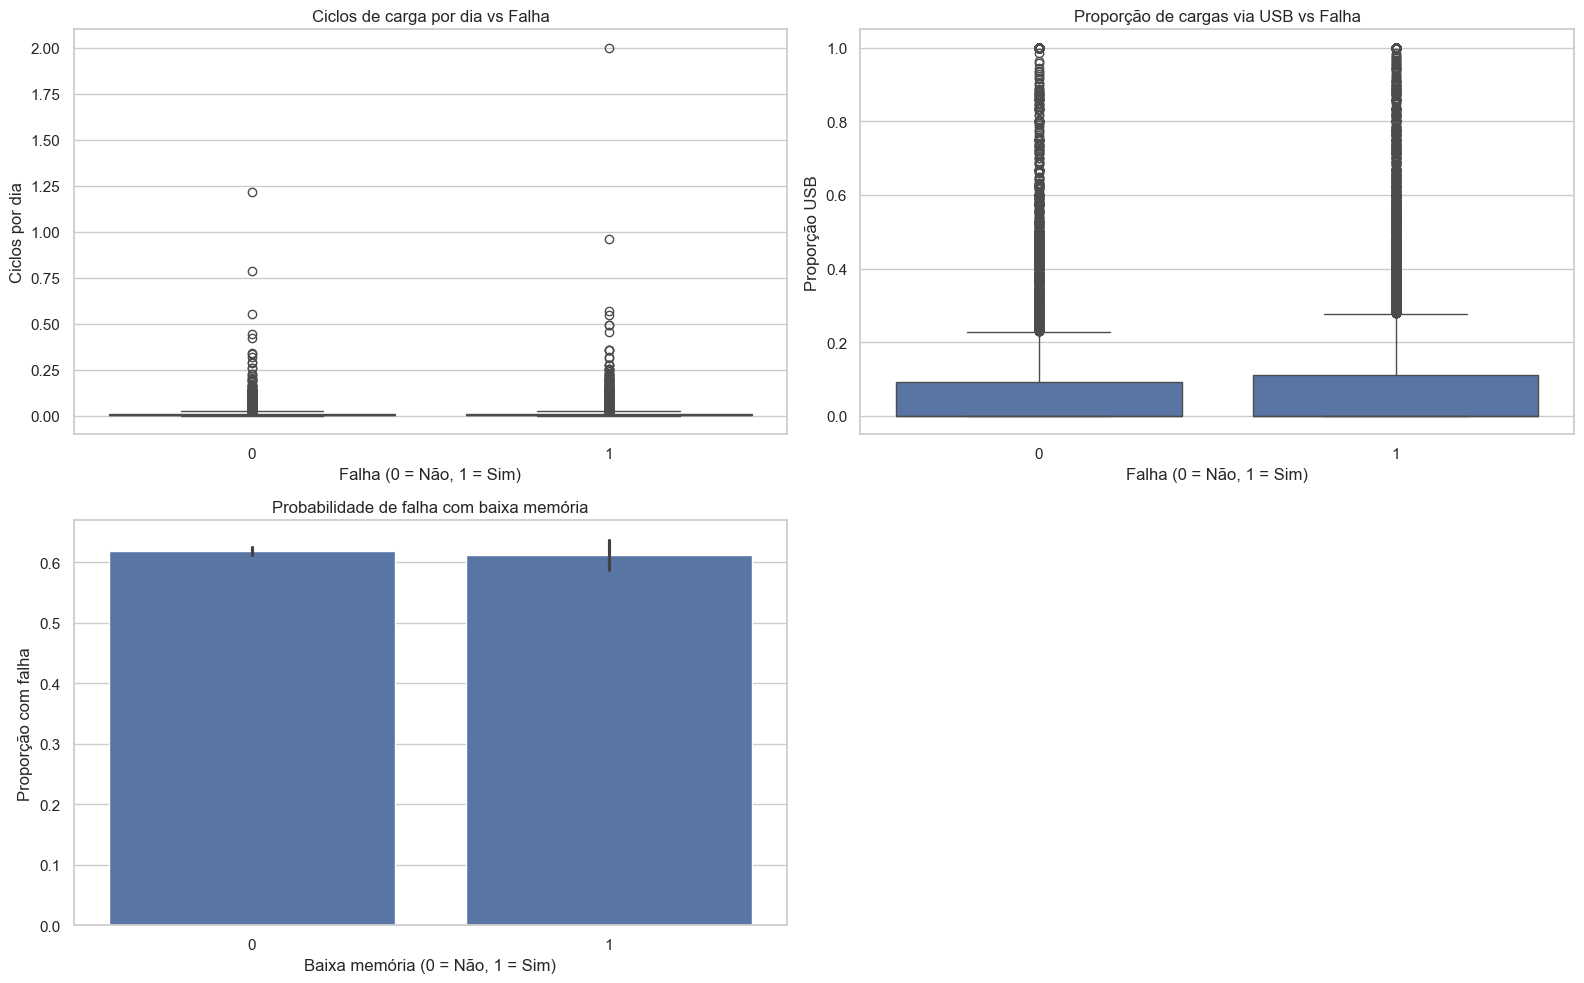

In [130]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

# 1. Boxplot: battery_cycles_per_day vs has_failure
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='has_failure', y='battery_cycles_per_day')
plt.title("Ciclos de carga por dia vs Falha")
plt.xlabel("Falha (0 = Não, 1 = Sim)")
plt.ylabel("Ciclos por dia")

# 2. Boxplot: usb_charge_ratio vs has_failure
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='has_failure', y='usb_charge_ratio')
plt.title("Proporção de cargas via USB vs Falha")
plt.xlabel("Falha (0 = Não, 1 = Sim)")
plt.ylabel("Proporção USB")

# 3. Barplot: low_memory_flag vs has_failure
plt.subplot(2, 2, 3)
sns.barplot(data=df, x='low_memory_flag', y='has_failure')
plt.title("Probabilidade de falha com baixa memória")
plt.xlabel("Baixa memória (0 = Não, 1 = Sim)")
plt.ylabel("Proporção com falha")

plt.tight_layout()
plt.show()

In [131]:
# 1. Média de ciclos de carga por dia
df['charge_rate'] = df['total_chrg_cnt'] / df['age_days']
# Mais cargas por dia podem indicar uso intenso (ou problema de bateria).

# 2. Proporção de cargas via USB
df['usb_charging_ratio'] = df['cnt_USB_chrg'] / df['total_chrg_cnt'].clip(lower=1)
# Pode mostrar padrão de uso diferente (ex: carga em emergência, sem carregador original).

# 3. Uso proporcional de cada rede
df['mobile_network_score'] = (
    1 * df['ratio_3G'] + 2 * df['ratio_4G'] + 3 * df['ratio_5G']
)
# Quanto mais 5G, melhor a conexão esperada. Pode afetar estabilidade.

# 4. Média de duração por chamada
#df['avg_call_duration'] = df['call_tot_mins'] / df['calls_tot'].clip(lower=1)
# Chamadas muito curtas podem indicar quedas ou falhas.

# 5. Tráfego de dados total
df['total_data_MB'] = df['mobile_rx_MB'] + df['mobile_tx_MB']
# Reflete uso da rede — tráfego mais alto pode estar relacionado a travamentos em apps.

# 6. Taxa de chamadas e mensagens por dia
#df['calls_per_day'] = df['calls_tot'] / df['age_days'].clip(lower=1)
#df['msgs_per_day'] = df['msgs_tot'] / df['age_days'].clip(lower=1)

# 7. Crash por tempo de tela
df['crash_per_hour'] = df['CRASH_total_ratio'] / df['son_hrs'].clip(lower=1)
#Permite identificar se o dispositivo apresenta muitos travamentos em pouco tempo de uso.

# 8. Memória interna baixa (flag binária)
df['low_memory_flag'] = (df['primary_mem_free_MB'] < 500).astype(int)

In [133]:
# Correlação com has_failure
"""new_features = [
    'charge_rate', 'usb_charging_ratio', 'mobile_network_score',
    'avg_call_duration', 'total_data_MB', 'calls_per_day',
    'msgs_per_day', 'crash_per_hour', 'low_memory_flag'
]"""
new_features = [
    'charge_rate', 'usb_charging_ratio', 'mobile_network_score',
    'total_data_MB', 'crash_per_hour', 'low_memory_flag'
]

correlacoes = df[new_features + ['has_failure']].corr()['has_failure'].drop('has_failure')
print("Correlação com has_failure:")
print(correlacoes.sort_values(key=abs, ascending=False))


Correlação com has_failure:
charge_rate             0.006352
total_data_MB           0.006024
mobile_network_score   -0.003751
low_memory_flag        -0.003349
crash_per_hour         -0.002530
usb_charging_ratio     -0.001738
Name: has_failure, dtype: float64


In [134]:
# Média de cada feature para quem teve falha (1) e quem não teve (0)
df.groupby('has_failure')[new_features].mean().T


has_failure,0,1
charge_rate,0.011814,0.012188
usb_charging_ratio,0.108354,0.107568
mobile_network_score,133.816776,133.187115
total_data_MB,117.078514,120.666871
crash_per_hour,0.300284,0.293357
low_memory_flag,0.068151,0.066426


In [135]:
print("Colunas atuais:", df.columns.tolist())

Colunas atuais: ['age_days', 'full_cap_min', 'pct_lvl_max', 'min_dchrg_fcc', 'dchrg_diff', 'EBL', 'total_chrg_cnt', 'cnt_USB_chrg', 'btlow_total', 'call_drop_sum', 'call_tot_mins', 'sst_poor_time_ratio', 'ratio_3G', 'ratio_4G', 'ratio_5G', 'wifi_hrs', 'wifi_connections', 'mobile_rx_MB', 'mobile_tx_MB', 'son_hrs', 'primary_mem_free_MB', 'bt_conns', 'CRASH_total', 'full_cap_min_ratio', 'EBL_ratio', 'total_chrg_cnt_ratio', 'cnt_USB_chrg_ratio', 'btlow_total_ratio', 'call_drop_sum_ratio', 'call_tot_mins_ratio', 'calls_tot_ratio', 'msgs_tot_ratio', 'pics_tot_ratio', 'sst_poor_time_ratio_ratio', 'ratio_3G_ratio', 'ratio_4G_ratio', 'ratio_5G_ratio', 'wifi_hrs_ratio', 'wifi_connections_ratio', 'mobile_rx_MB_ratio', 'mobile_tx_MB_ratio', 'son_hrs_ratio', 'primary_mem_free_MB_ratio', 'bt_conns_ratio', 'CRASH_total_ratio', 'has_failure', 'battery_cycles_per_day', 'usb_charge_ratio', 'low_memory_flag', 'charge_rate', 'usb_charging_ratio', 'mobile_network_score', 'total_data_MB', 'crash_per_hour']
